In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("Local_Area_Unemployment_Statistics__LAUS_1.csv", thousands=',', low_memory=False) 
data.drop_duplicates(keep = False, inplace = True)
data = data[data["Unemployment Rate"] != "#DIV/0!"]
data = data[data["Labor Force"] > 0]
counts = data["Area Name"].value_counts()
data = data[~data["Area Name"].isin(counts[counts < 120].index)]
data = data[data["Status (Preliminary / Final)"] != "Preliminary"]
data = data.drop(['Area Type', 'Date', 'Status (Preliminary / Final)', 'Employment', "Unemployment"], axis=1)
dic_month = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
            "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
data = data.replace(dic_month)
data["Month"].value_counts()

9     3644
8     3644
7     3644
6     3644
5     3644
4     3644
3     3644
2     3644
1     3644
10    3553
12    3523
11    3523
Name: Month, dtype: int64

In [ ]:
data["Unemployment Rate"] = data["Unemployment Rate"].astype(float)
sns.set(color_codes=True)
sns.distplot(data["Unemployment Rate"], kde=False, rug=True);
plt.savefig('Unemployment rate diagram.pdf')

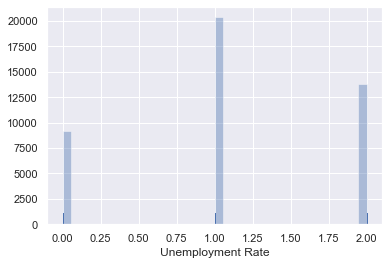

In [29]:
a = np.array(data['Unemployment Rate'].values.tolist())
data['Unemployment Rate'] = np.where(a > 0.1, 2, 
         (np.where(a < 0.05, 0, 1))).tolist() #Employment rate>0.1, high(2); 0.05<=<=0.1(1), medium; 0<0.05, low(0).
data["Unemployment Rate"].value_counts()
sns.set(color_codes=True)
sns.distplot(data["Unemployment Rate"], kde=False, rug=True);
plt.savefig('Three levels.pdf')

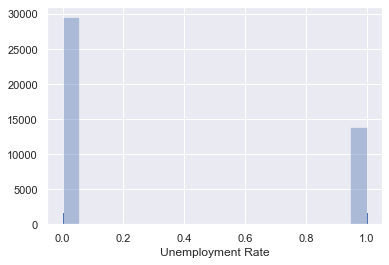

In [30]:
data_rule = data[:]
a = np.array(data['Unemployment Rate'].values.tolist())
data_rule['Unemployment Rate'] = np.where(a == 2, 1, 0).tolist() #Employment rate>0.1, high(1); 0<=0.1, low&medium(0).
data_rule["Unemployment Rate"].value_counts()
sns.set(color_codes=True)
sns.distplot(data_rule["Unemployment Rate"], kde=False, rug=True);
plt.savefig('Two levels.pdf')

In [31]:
data.head()

,Area Name,Year,Month,Seasonally Adjusted (Y/N),Labor Force,Unemployment Rate
0,California,1976,1,Y,9734600,1
1,California,1977,1,Y,10132600,1
2,California,1978,1,Y,10675100,1
3,California,1979,1,Y,11130900,1
4,California,1980,1,Y,11479800,1


In [32]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=["Area Name"])
y = data["Unemployment Rate"]
y_rule = data_rule["Unemployment Rate"]
X = data.drop("Unemployment Rate", axis=1)
encoder.fit(X, y)
X_enc = encoder.transform(X)
X_enc = pd.get_dummies(X_enc, columns=["Seasonally Adjusted (Y/N)"])

X_enc = pd.DataFrame(X_enc)
feature_names = list(X_enc.columns.values)
print(feature_names)

X_enc.head()

['Area Name_0', 'Area Name_1', 'Area Name_2', 'Area Name_3', 'Area Name_4', 'Area Name_5', 'Area Name_6', 'Area Name_7', 'Year', 'Month', 'Labor Force', 'Seasonally Adjusted (Y/N)_N', 'Seasonally Adjusted (Y/N)_Y']


,Area Name_0,Area Name_1,Area Name_2,Area Name_3,Area Name_4,Area Name_5,Area Name_6,Area Name_7,Year,Month,Labor Force,Seasonally Adjusted (Y/N)_N,Seasonally Adjusted (Y/N)_Y
0,0,0,0,0,0,0,0,1,1976,1,9734600,0,1
1,0,0,0,0,0,0,0,1,1977,1,10132600,0,1
2,0,0,0,0,0,0,0,1,1978,1,10675100,0,1
3,0,0,0,0,0,0,0,1,1979,1,11130900,0,1
4,0,0,0,0,0,0,0,1,1980,1,11479800,0,1


In [33]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
data_scale = min_max_scaler.fit_transform(X_enc)
X_enc = pd.DataFrame(data_scale)

feature_dict = {}
for i in range(len(feature_names)):
    feature_dict[i] = feature_names[i]
X_enc = X_enc.rename(columns=feature_dict)
X_enc.head()

# Features: 13

,Area Name_0,Area Name_1,Area Name_2,Area Name_3,Area Name_4,Area Name_5,Area Name_6,Area Name_7,Year,Month,Labor Force,Seasonally Adjusted (Y/N)_N,Seasonally Adjusted (Y/N)_Y
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.000000,-1.0,-0.006497,-1.0,1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.953488,-1.0,0.034123,-1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.906977,-1.0,0.089491,-1.0,1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.860465,-1.0,0.136011,-1.0,1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-0.813953,-1.0,0.171620,-1.0,1.0


In [34]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_over, y_over = sm.fit_sample(X_enc, y)
print("After OverSampling, counts of label '2': {}".format(sum(y_over==2)))
print("After OverSampling, counts of label '1': {}".format(sum(y_over==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_over==0)))
print("-------------------------------------------------------------")

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2)
X_und, y_und = rus.fit_resample(X_enc, y)
print("After UnderSampling, counts of label '2': {}".format(sum(y_und==2)))
print("After UnderSampling, counts of label '1': {}".format(sum(y_und==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_und==0)))
print("-------------------------------------------------------------")

from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
X_bal, y_bal = sme.fit_resample(X_enc, y)
print("After BalancedSampling, counts of label '2': {}".format(sum(y_bal==2)))
print("After BalancedSampling, counts of label '1': {}".format(sum(y_bal==1)))
print("After BalancedSampling, counts of label '0': {}".format(sum(y_bal==0)))
print("-------------------------------------------------------------")

X_over_rule, y_over_rule = sm.fit_sample(X_enc, y_rule)
print("After OverSampling, counts of label '1': {}".format(sum(y_over_rule==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_over_rule==0)))
print("-------------------------------------------------------------")

X_und_rule, y_und_rule = rus.fit_resample(X_enc, y_rule)
print("After UnderSampling, counts of label '1': {}".format(sum(y_und_rule==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_und_rule==0)))
print("-------------------------------------------------------------")

X_bal_rule, y_bal_rule = sme.fit_resample(X_enc, y_rule)
print("After BalancedSampling, counts of label '1': {}".format(sum(y_bal_rule==1)))
print("After BalancedSampling, counts of label '0': {}".format(sum(y_bal_rule==0)))

After OverSampling, counts of label '2': 20381
After OverSampling, counts of label '1': 20381
After OverSampling, counts of label '0': 20381
-------------------------------------------------------------
After UnderSampling, counts of label '2': 9180
After UnderSampling, counts of label '1': 9180
After UnderSampling, counts of label '0': 9180
-------------------------------------------------------------
After BalancedSampling, counts of label '2': 15567
After BalancedSampling, counts of label '1': 9324
After BalancedSampling, counts of label '0': 15536
-------------------------------------------------------------
After OverSampling, counts of label '1': 29561
After OverSampling, counts of label '0': 29561
-------------------------------------------------------------
After UnderSampling, counts of label '1': 13834
After UnderSampling, counts of label '0': 13834
-------------------------------------------------------------
After BalancedSampling, counts of label '1': 25213
After BalancedS

In [50]:
from sklearn import linear_model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from skrules import SkopeRules
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from prettytable import PrettyTable
import warnings

warnings.filterwarnings('ignore')
def cv_train_test_split(X, y):
    X_Train, Y_Train, X_Test, Y_Test = [], [], [], []
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_Train.append(X_train)
            X_Test.append(X_test)
            Y_Train.append(y_train)
            Y_Test.append(y_test)
    return X_Train, Y_Train, X_Test, Y_Test

feature_train_over, label_train_over, feature_test_over, label_test_over = cv_train_test_split(X_over, y_over)
feature_train_ru_over, label_train_ru_over, feature_test_ru_over, label_test_ru_over = cv_train_test_split(X_over_rule, y_over_rule)

feature_train_und, label_train_und, feature_test_und, label_test_und = cv_train_test_split(X_und, y_und)
feature_train_ru_und, label_train_ru_und, feature_test_ru_und, label_test_ru_und = cv_train_test_split(X_und_rule, y_und_rule)

feature_train_bal, label_train_bal, feature_test_bal, label_test_bal = cv_train_test_split(X_bal, y_bal)
feature_train_ru_bal, label_train_ru_bal, feature_test_ru_bal, label_test_ru_bal = cv_train_test_split(X_bal_rule, y_bal_rule)

def model(m, feature_train, label_train, feature_test, label_test, X, y):
    if m == "linear":
        warnings.filterwarnings('ignore')
        lin_cla  = linear_model.SGDClassifier(loss='modified_huber') # default: ‘hinge’
        print(reset + "Linear-based Model:")
        printScore(lin_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(lin_cla, X, y)
    if m == "linear1":
        warnings.filterwarnings('ignore')
        lin_cla1  = OneVsRestClassifier(LinearSVC(random_state=0, multi_class='ovr'))
        # We use the linear support vecotr classification LinearSVC with the OneVsRestClassifier wrapper
        # OneVsRestClassifier is a multiclass strategy. 
        # We set the LinearSVC's multi class as "ovr" (multi-class strategy)
        #"ovr" trains n classes one-vs-rest classifiers 
        print(reset + "Linear-based Model 2:")
        printScore(lin_cla1, feature_train, label_train, feature_test, label_test)
        cla_wrong(lin_cla1, X, y)
    elif m == "tree":
        tree_cla = tree.DecisionTreeClassifier(criterion = "entropy") # default: gini
        print(reset + "Tree-based Model:")
        printScore(tree_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(tree_cla, X, y)
    elif m == "bagging": 
        bagging_cla = BaggingClassifier() # decision tree is the base estimator
        print(reset + "Bagging-based Model:")
        printScore(bagging_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(bagging_cla, X, y)
    elif m == "boosting":
        boosting_cla = AdaBoostClassifier(tree.DecisionTreeClassifier(), n_estimators=100, random_state=0)
        # default: 50, the maximum number of estimators at which boosting is terminated.
        print(reset + "Boosting-based Model:")
        printScore(boosting_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(boosting_cla, X, y)
    elif m == "neighbors":
        neigh_cla = KNeighborsClassifier(n_neighbors=5, p=5)
        #tried 3 and 5, 5 is better. 
        #p: default 2(Euclidean distance); 5: minkowski distance; 1, manhattan distance 
        print(reset + "Distance-based Model: ")
        printScore(neigh_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(neigh_cla, X, y)
    elif m == "bayes":
        nb_cla = GaussianNB() 
        print(reset + "Naive Bayes Model: ")
        printScore(nb_cla, feature_train, label_train, feature_test, label_test)
        cla_wrong(nb_cla, X, y)
    elif m == "rule":
        warnings.filterwarnings('ignore')
        rb_cla = SkopeRules(max_depth_duplication=3,
                 n_estimators=30,
                 precision_min=0.6,
                 recall_min=0.01)
        print(reset + "Rule-based Model: lables are only high unemployment rate(1) and not high unemployment rate(0)")
        printScore_rule(rb_cla, feature_train, label_train, feature_test, label_test)
        
def printScore(model, feature_train, label_train, feature_test, label_test):
        t = PrettyTable(['id', 'accuracy', 'pre[h]', 'rec[h]', 'f1[h]', 'pre[m]', 'rec[m]', 'f1[m]',
                        'pre[l]', 'rec[l]', 'f1[l]', 'f[avg_macro]'])
        sum_acc, sum_pre, sum_rec, sum_f, sum_pre2, sum_rec2, sum_f2, sum_pre1, sum_rec1, sum_f1, sum_f_total = 0,0,0,0,0,0,0,0,0,0,0
        for i in range(10):
            model.fit(feature_train[i], label_train[i])
            y_pred = model.predict(feature_test[i])
            acc = accuracy_score(label_test[i], y_pred)
            pre = precision_score(label_test[i], y_pred, average = None, labels = [2])
            rec = recall_score(label_test[i], y_pred, average = None, labels = [2])
            f_score = f1_score(label_test[i], y_pred, average = None, labels = [2])
            pre2 = precision_score(label_test[i], y_pred, average = None, labels = [1])
            rec2 = recall_score(label_test[i], y_pred, average = None, labels = [1])
            f_score2 = f1_score(label_test[i], y_pred, average = None, labels = [1])
            pre1 = precision_score(label_test[i], y_pred, average = None, labels = [0])
            rec1 = recall_score(label_test[i], y_pred, average = None, labels = [0])
            f_score1 = f1_score(label_test[i], y_pred, average = None, labels = [0])
            f_score_total = f1_score(label_test[i], y_pred, average = "macro")
            t.add_row([i+1, '{0:.3f}'.format(float(acc)), '{0:.3f}'.format(float(pre)), '{0:.3f}'.format(float(rec)),
                      '{0:.3f}'.format(float(f_score)), '{0:.3f}'.format(float(pre2)), '{0:.3f}'.format(float(rec2)),
                      '{0:.3f}'.format(float(f_score2)),
                      '{0:.3f}'.format(float(pre1)), '{0:.3f}'.format(float(rec1)),
                      '{0:.3f}'.format(float(f_score1)),'{0:.3f}'.format(float(f_score_total))])
            sum_acc += float(acc)
            sum_pre += float(pre)
            sum_rec += float(rec)
            sum_f += float(f_score)
            sum_pre2 += float(pre2)
            sum_rec2 += float(rec2)
            sum_f2 += float(f_score2)
            sum_pre1 += float(pre1)
            sum_rec1 += float(rec1)
            sum_f1 += float(f_score1)
            sum_f_total += float(f_score_total)
        avg_acc = sum_acc/10
        avg_pre = sum_pre/10
        avg_rec = sum_rec/10
        avg_f = sum_f/10
        avg_pre2 = sum_pre2/10
        avg_rec2 = sum_rec2/10
        avg_f2 = sum_f2/10
        avg_pre1 = sum_pre1/10
        avg_rec1 = sum_rec1/10
        avg_f1 = sum_f1/10
        avg_f_total = sum_f_total/10
        t.add_row([" Average ", '{0:.3f}'.format(avg_acc), '{0:.3f}'.format(avg_pre), '{0:.3f}'.format(avg_rec),
                  '{0:.3f}'.format(avg_f),'{0:.3f}'.format(avg_pre2), '{0:.3f}'.format(avg_rec2),
                  '{0:.3f}'.format(avg_f2), '{0:.3f}'.format(avg_pre1), '{0:.3f}'.format(avg_rec1),
                  '{0:.3f}'.format(avg_f1), '{0:.3f}'.format(avg_f_total)])
        print(t)
        

def printScore_rule(model, feature_train, label_train, feature_test, label_test):
        t = PrettyTable(['id', 'accuracy', 'precision', 'recall', 'f1 score'])
        sum_acc, sum_pre, sum_rec, sum_f= 0,0,0,0
        for i in range(10):
            model.fit(feature_train[i], label_train[i])
            y_pred = model.predict(feature_test[i])
            acc = accuracy_score(label_test[i], y_pred)
            pre = precision_score(label_test[i], y_pred, average = 'binary')
            rec = recall_score(label_test[i], y_pred, average = 'binary')
            f_score = f1_score(label_test[i], y_pred, average = 'binary')
            # Only report results for the class specified by pos_label
            t.add_row([i+1, '{0:.3f}'.format(acc), '{0:.3f}'.format(pre), '{0:.3f}'.format(rec),
                      '{0:.3f}'.format(f_score)])
            sum_acc += float(acc)
            sum_pre += float(pre)
            sum_rec += float(rec)
            sum_f += float(f_score)
        avg_acc = sum_acc/10
        avg_pre = sum_pre/10
        avg_rec = sum_rec/10
        avg_f = sum_f/10
        t.add_row([" Average ", '{0:.3f}'.format(avg_acc), '{0:.3f}'.format(avg_pre), '{0:.3f}'.format(avg_rec),
                  '{0:.3f}'.format(avg_f)])
        print(t)

        
X_dic = dict()
def cla_wrong(model, f_data, l_data):
        y_pred = model.predict(f_data)
        for i in range(len(l_data)):
            if l_data[i]!=y_pred[i]:
                if i in dict.keys(X_dic):
                    X_dic[i] +=1
                else:
                    X_dic[i] =1

def cla_often_wrong(X_dic, X, y, sample):
    X_wrong, Y_wrong = [], []
    X_dic = {key: value for (key, value) in X_dic.items() if value == 7 }
    for key in X_dic.keys():
        X_wrong.append(X[key])
        Y_wrong.append(y[key])
    data_wrong = pd.DataFrame(X_wrong)
    data_wrong["Unemployment Rate"] = pd.DataFrame(Y_wrong)
    feature_dict = {}
    for i in range(len(feature_names)):
        feature_dict[i] = feature_names[i]
    data_wrong = data_wrong.rename(columns=feature_dict)
#   print(data_wrong.head())
    print("Instances are often misclassified: ", len(X_dic))
    
    if sample == "over":
        data_wrong.to_excel("Oversampling_misclassified.xlsx")  
        
    elif sample == "und":
        data_wrong.to_excel("Undersampling_misclassified.xlsx")  
            
    if sample == "bal":
        data_wrong.to_excel("Balancedsampling_misclassified.xlsx")  
        
bold = "\033[1m" 
reset = "\033[0;0m"
print(bold + "After Over Sampling: ---------------------------------------------------------------------------")
model("linear", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("linear1", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("tree", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("bagging", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("boosting", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("neighbors", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("bayes", feature_train_over, label_train_over, feature_test_over, label_test_over, X_over, y_over)
model("rule", feature_train_ru_over, label_train_ru_over, feature_test_ru_over, label_test_ru_over, X_over_rule, y_over_rule)
cla_often_wrong(X_dic, X_over, y_over, "over")

X_dic = dict()
print(bold + "After Under Sampling: ---------------------------------------------------------------------------")
model("linear", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("linear1", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("tree", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("bagging", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("boosting", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("neighbors", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("bayes", feature_train_und, label_train_und, feature_test_und, label_test_und, X_und, y_und)
model("rule", feature_train_ru_und, label_train_ru_und, feature_test_ru_und, label_test_ru_und, X_und_rule, y_und_rule)
cla_often_wrong(X_dic, X_und, y_und, "und")


X_dic = dict()
print(bold + "After Balanced Sampling: ---------------------------------------------------------------------------")
model("linear", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("linear1", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("tree", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("bagging", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("boosting", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("neighbors", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("bayes", feature_train_bal, label_train_bal, feature_test_bal, label_test_bal, X_bal, y_bal)
model("rule", feature_train_ru_bal, label_train_ru_bal, feature_test_ru_bal, label_test_ru_bal, X_bal_rule, y_bal_rule)
cla_often_wrong(X_dic, X_bal, y_bal, "bal")


After Over Sampling: ---------------------------------------------------------------------------
Linear-based Model:
+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     id    | accuracy | pre[h] | rec[h] | f1[h] | pre[m] | rec[m] | f1[m] | pre[l] | rec[l] | f1[l] | f[avg_macro] |
+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     1     |  0.420   | 0.403  | 0.852  | 0.547 | 0.448  | 0.128  | 0.198 | 0.468  | 0.281  | 0.351 |    0.365     |
|     2     |  0.372   | 0.497  | 0.428  | 0.460 | 0.323  | 0.667  | 0.435 | 0.310  | 0.022  | 0.041 |    0.312     |
|     3     |  0.357   | 0.514  | 0.334  | 0.405 | 0.287  | 0.377  | 0.326 | 0.346  | 0.359  | 0.352 |    0.361     |
|     4     |  0.268   | 0.338  | 0.205  | 0.255 | 0.236  | 0.148  | 0.182 | 0.256  | 0.452  | 0.326 |    0.255     |
|     5     |  0.350   | 0.345  | 0.234  | 0.279 | 0.334 

+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     id    | accuracy | pre[h] | rec[h] | f1[h] | pre[m] | rec[m] | f1[m] | pre[l] | rec[l] | f1[l] | f[avg_macro] |
+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     1     |  0.732   | 0.772  | 0.969  | 0.860 | 0.754  | 0.329  | 0.458 | 0.686  | 0.898  | 0.778 |    0.698     |
|     2     |  0.751   | 0.856  | 0.954  | 0.903 | 0.714  | 0.442  | 0.546 | 0.677  | 0.858  | 0.757 |    0.735     |
|     3     |  0.706   | 0.812  | 0.870  | 0.840 | 0.619  | 0.390  | 0.479 | 0.661  | 0.859  | 0.747 |    0.689     |
|     4     |  0.671   | 0.765  | 0.720  | 0.742 | 0.517  | 0.422  | 0.465 | 0.700  | 0.869  | 0.776 |    0.661     |
|     5     |  0.657   | 0.703  | 0.720  | 0.711 | 0.486  | 0.345  | 0.404 | 0.715  | 0.904  | 0.799 |    0.638     |
|     6     |  0.713   | 0.752  | 0.787  | 0.769 | 0.607

+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     id    | accuracy | pre[h] | rec[h] | f1[h] | pre[m] | rec[m] | f1[m] | pre[l] | rec[l] | f1[l] | f[avg_macro] |
+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     1     |  0.767   | 0.862  | 0.919  | 0.890 | 0.638  | 0.878  | 0.739 | 0.902  | 0.503  | 0.646 |    0.758     |
|     2     |  0.809   | 0.883  | 0.942  | 0.911 | 0.692  | 0.861  | 0.767 | 0.907  | 0.624  | 0.739 |    0.806     |
|     3     |  0.863   | 0.916  | 0.920  | 0.918 | 0.760  | 0.877  | 0.814 | 0.939  | 0.791  | 0.859 |    0.864     |
|     4     |  0.877   | 0.933  | 0.919  | 0.926 | 0.793  | 0.869  | 0.830 | 0.918  | 0.843  | 0.879 |    0.878     |
|     5     |  0.885   | 0.924  | 0.928  | 0.926 | 0.811  | 0.858  | 0.834 | 0.927  | 0.868  | 0.897 |    0.885     |
|     6     |  0.883   | 0.924  | 0.942  | 0.933 | 0.812

Rule-based Model: lables are only high unemployment rate(1) and not high unemployment rate(0)
+-----------+----------+-----------+--------+----------+
|     id    | accuracy | precision | recall | f1 score |
+-----------+----------+-----------+--------+----------+
|     1     |  0.592   |   0.720   | 0.300  |  0.423   |
|     2     |  0.587   |   0.712   | 0.293  |  0.415   |
|     3     |  0.617   |   0.737   | 0.365  |  0.488   |
|     4     |  0.668   |   0.809   | 0.439  |  0.569   |
|     5     |  0.701   |   0.814   | 0.521  |  0.636   |
|     6     |  0.676   |   0.811   | 0.459  |  0.586   |
|     7     |  0.678   |   0.800   | 0.474  |  0.595   |
|     8     |  0.648   |   0.776   | 0.416  |  0.541   |
|     9     |  0.645   |   0.778   | 0.406  |  0.533   |
|     10    |  0.654   |   0.790   | 0.419  |  0.548   |
|  Average  |  0.647   |   0.775   | 0.409  |  0.533   |
+-----------+----------+-----------+--------+----------+
Instances are often misclassified:  41
After Balanc

+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     id    | accuracy | pre[h] | rec[h] | f1[h] | pre[m] | rec[m] | f1[m] | pre[l] | rec[l] | f1[l] | f[avg_macro] |
+-----------+----------+--------+--------+-------+--------+--------+-------+--------+--------+-------+--------------+
|     1     |  0.947   | 0.953  | 0.982  | 0.967 | 0.937  | 0.845  | 0.888 | 0.947  | 0.974  | 0.961 |    0.939     |
|     2     |  0.937   | 0.955  | 0.963  | 0.959 | 0.899  | 0.837  | 0.867 | 0.941  | 0.972  | 0.957 |    0.927     |
|     3     |  0.946   | 0.950  | 0.981  | 0.965 | 0.912  | 0.857  | 0.884 | 0.962  | 0.965  | 0.963 |    0.937     |
|     4     |  0.936   | 0.987  | 0.889  | 0.935 | 0.833  | 0.914  | 0.872 | 0.957  | 0.997  | 0.977 |    0.928     |
|     5     |  0.934   | 0.947  | 0.914  | 0.930 | 0.851  | 0.879  | 0.865 | 0.972  | 0.987  | 0.979 |    0.925     |
|     6     |  0.960   | 0.964  | 0.998  | 0.981 | 0.991